In [1]:
import pandas as pd
import numpy as np

df_0 = pd.read_csv(u"datos_limpios/2010.csv")
df_1 = pd.read_csv(u"datos_limpios/2011.csv")
df_2 = pd.read_csv(u"datos_limpios/2012.csv")
df_3 = pd.read_csv(u"datos_limpios/2013.csv")
df_4 = pd.read_csv(u"datos_limpios/2014.csv")
df_5 = pd.read_csv(u"datos_limpios/2015.csv")
df_6 = pd.read_csv(u"datos_limpios/2016.csv")
df_7 = pd.read_csv(u"datos_limpios/2017.csv")

C:\Users\Javi\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
df_0to7 = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
df_0to7 = df_0to7.reset_index(drop=True)

In [3]:
# Selección de columnas
sub_df_0to7 = df_0to7[["GEN_ALU",
               'cat_periodo',
               'anio_ing_carr_ori',
               'anio_ing_carr_act',
               "rango_edad", 
               "tipo_inst_3", 
               "jornada", 
               "tipo_plan_carr", 
               "dur_estudio_carr", 
               "nivel_carrera_1", 
               "nivel_global", 
               "oecd_area", 
               "acreditada_carr", 
               "acreditada_inst"]]

# Restricción a solo datos de pregrado
sub_df_0to7 = (sub_df_0to7.query("nivel_global=='Pregrado' or nivel_global.isnull()")
                         .drop(columns = ['nivel_global'])
                         .dropna(subset=['anio_ing_carr_act']))

sub_df_0to7['anio_en_carr_actual'] = sub_df_0to7['anio_ing_carr_act'] - sub_df_0to7['cat_periodo']

# se pide que cat_periodo == anio_ing_carr_act para no contar a una misma persona todos los años
sub_df_0to7['Class'] = sub_df_0to7.apply(lambda row: row.cat_periodo != row.anio_ing_carr_ori and row.cat_periodo == row.anio_ing_carr_act, axis = 1)
sub_df_0to7 = sub_df_0to7.drop(columns = ['anio_ing_carr_ori', 'cat_periodo', 'anio_ing_carr_act'])

sub_df_0to7['acreditada_carr'] = sub_df_0to7['acreditada_carr'].replace('NO ACREDITADA', False, regex=True)
sub_df_0to7['acreditada_carr'] = sub_df_0to7['acreditada_carr'].replace('ACREDITADA', True, regex=True)
sub_df_0to7['acreditada_inst'] = sub_df_0to7['acreditada_inst'].replace('NO ACREDITADA', False, regex=True)
sub_df_0to7['acreditada_inst'] = sub_df_0to7['acreditada_inst'].replace('ACREDITADA', True, regex=True)

In [4]:
# Se obtienen los tipos de cada columa en un dataframe
sub_df_0to7_datatypes = (pd.DataFrame(sub_df_0to7.dtypes)
                    .reset_index()
                    .rename(columns = {0:'tipo', 'index' : 'columna'})
                    )

# para cada columna...
cols_name = list(sub_df_0to7).remove('GEN_ALU')
df_sub_one_hot = pd.get_dummies(sub_df_0to7[['GEN_ALU']], prefix='GEN_ALU')
for i in range(1, len(sub_df_0to7_datatypes)):
    col_name = sub_df_0to7_datatypes.iloc[i][0]
    
    # Si es que es de tipo object...
    if str(sub_df_0to7_datatypes.iloc[i][1]) == 'object':
        # se le aplica la transformación One Hot
        df_one_hot = pd.get_dummies(sub_df_0to7[[col_name]], prefix=col_name)
    else:
        df_one_hot = sub_df_0to7[[col_name]]
    df_sub_one_hot = pd.merge(df_sub_one_hot, df_one_hot, left_index=True, right_index=True)

df_sub_one_hot = df_sub_one_hot.reset_index(drop=True)

<AxesSubplot:>

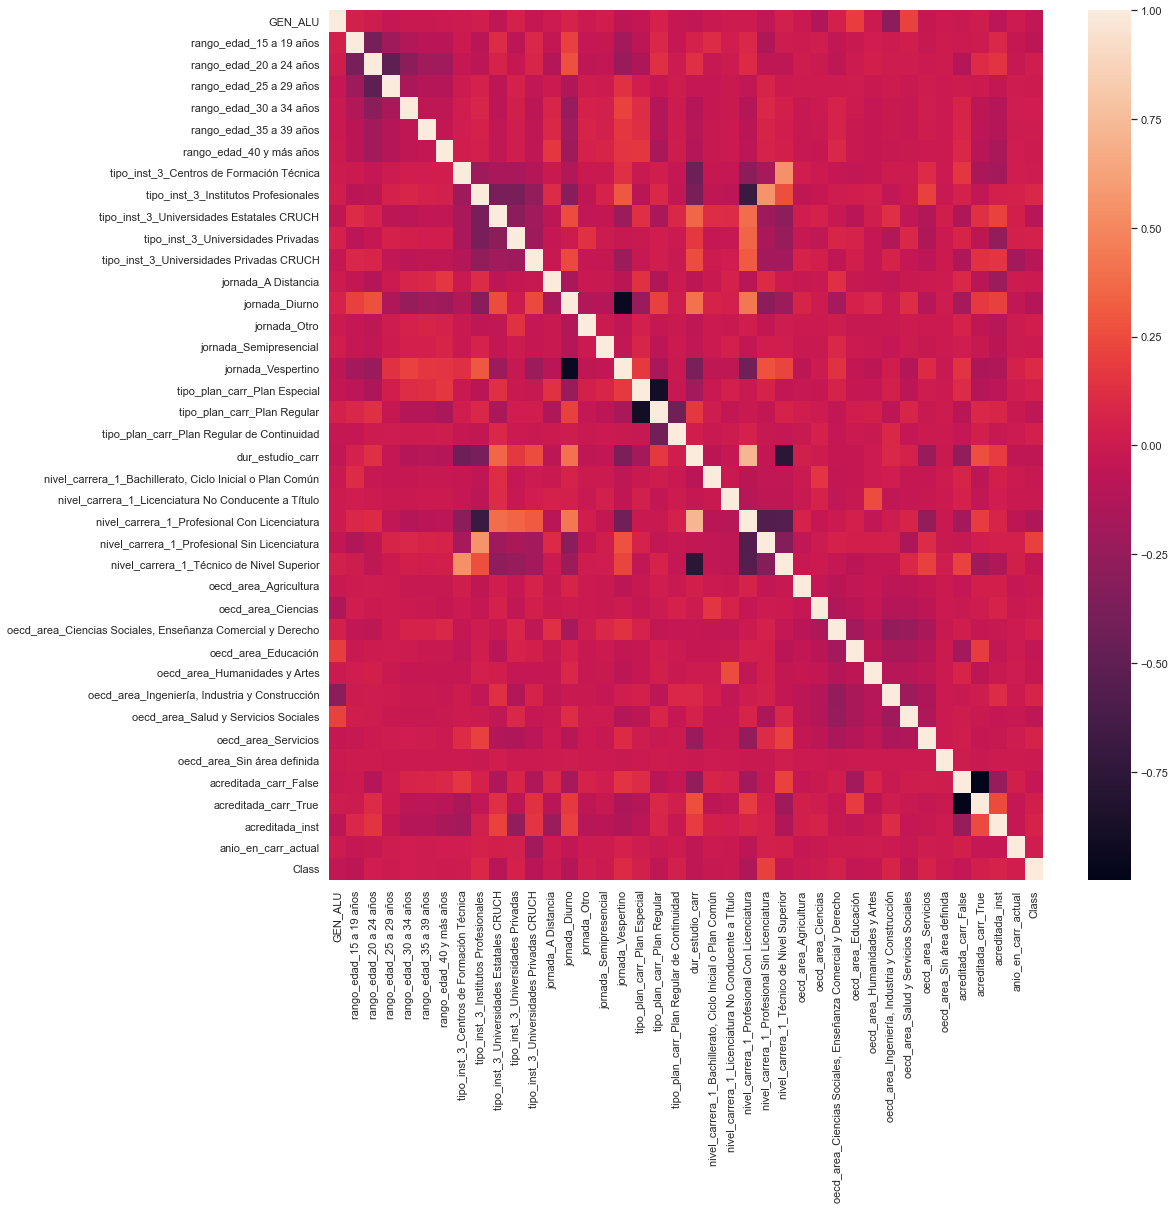

In [5]:
import seaborn

# Se aplica One Hot
corr_sub = df_sub_one_hot.corr()
seaborn.set(rc={'figure.figsize':(16,16)})
seaborn.heatmap(corr_sub)

In [6]:
# se eliminan columnas con correlación alta y se eliminan las filas que puedan haber quedado con valores nulos
df_sub_one_hot = df_sub_one_hot.drop(columns = ['tipo_plan_carr_Plan Regular', 'jornada_Diurno', 'acreditada_carr_False']).dropna()

Se decide observar, en primera instancia, el rendimiento de los clasificadores al ser entrenados con solo el $0,5\%$ de los datos, es decir, $10000$ entradas aproximadamente. Esto por la cantidad de datos que contiene el dataframe completo.

In [7]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

def get_data_dict(df, testSize):
    data_train, data_test, ytrain, ytest = train_test_split(df, df['Class'], test_size=testSize, stratify=df['Class'])
    diferencia = ytrain.value_counts()[False]-ytrain.value_counts()[True]
    data_train = data_train.reset_index(drop=True)

    # oversampling sobre la clase True
    idx = np.random.choice(data_train[data_train['Class'] == True].index, size=diferencia)
    data_oversampled = pd.concat([data_train, data_train.iloc[idx]])
    print("Data oversampled on class 'True'")
    print(data_oversampled['Class'].value_counts())

    # subsampling sobre la clase False
    idx = np.random.choice(data_train.loc[data_train.Class == False].index, size=diferencia, replace=False)
    data_subsampled = data_train.drop(data_train.iloc[idx].index)
    print("Data subsampled on class 'False'")
    print(data_subsampled['Class'].value_counts())
    
    # Se definen los conjuntos de testeo
    X_test = data_test[data_train.columns[:-1]]
    y_test = data_test[data_train.columns[-1]]

    # datos entrenamiento "originales"
    X_orig = data_train[data_train.columns[:-1]] 
    y_orig = data_train[data_train.columns[-1]] 

    # datos entrenamiento "oversampleados" 
    X_over = data_oversampled[data_train.columns[:-1]]
    y_over = data_oversampled[data_train.columns[-1]]

    # datos entrenamiento "subsampleados"
    X_subs = data_subsampled[data_train.columns[:-1]]
    y_subs = data_subsampled[data_train.columns[-1]]
    
    return {'X_test': X_test, 'y_test': y_test, 'X_orig': X_orig, 'y_orig': y_orig, 'X_over': X_over, 'y_over': y_over, 'X_subs': X_subs, 'y_subs': y_subs}

In [8]:
from sklearn.metrics import classification_report

def train(Classifier, data_dict):
    print("::::::::::Datos originales")
    clf_orig = Classifier()
    clf_orig.fit(data_dict['X_orig'], data_dict['y_orig'])
    pred_orig = clf_orig.predict(data_dict['X_test'])
    print(classification_report(data_dict['y_test'], pred_orig))

    print("::::::::::Datos con oversampling")
    clf_over = Classifier()
    clf_over.fit(data_dict['X_over'], data_dict['y_over'])
    pred_over = clf_over.predict(data_dict['X_test'])
    print(classification_report(data_dict['y_test'], pred_over))

    print("::::::::::Datos con subsampling")
    clf_subs = Classifier()
    clf_subs.fit(data_dict['X_subs'], data_dict['y_subs'])
    pred_subs = clf_subs.predict(data_dict['X_test'])
    print(classification_report(data_dict['y_test'], pred_subs))
    
    return clf_orig, clf_over, clf_subs

In [9]:
data_dict = get_data_dict(df_sub_one_hot, testSize = 0.995)

Data oversampled on class 'True'
True     9205
False    9205
Name: Class, dtype: int64
Data subsampled on class 'False'
True     955
False    955
Name: Class, dtype: int64


In [10]:
from sklearn.tree import DecisionTreeClassifier

print("Resultados para Árbol de Decisión")
DTC_orig, DTC_over, DTC_subs = train(DecisionTreeClassifier, data_dict)

Resultados para Árbol de Decisión
::::::::::Datos originales
              precision    recall  f1-score   support

       False       0.97      0.98      0.97   1831973
        True       0.76      0.68      0.72    190001

    accuracy                           0.95   2021974
   macro avg       0.86      0.83      0.84   2021974
weighted avg       0.95      0.95      0.95   2021974

::::::::::Datos con oversampling
              precision    recall  f1-score   support

       False       0.98      0.95      0.96   1831973
        True       0.60      0.77      0.68    190001

    accuracy                           0.93   2021974
   macro avg       0.79      0.86      0.82   2021974
weighted avg       0.94      0.93      0.93   2021974

::::::::::Datos con subsampling
              precision    recall  f1-score   support

       False       0.99      0.90      0.94   1831973
        True       0.47      0.88      0.61    190001

    accuracy                           0.89   2021974
  

In [11]:
from sklearn.naive_bayes import GaussianNB  # Naive bayes

print("Resultados para Naive bayes")
NB_orig, NB_over, NB_subs = train(GaussianNB, data_dict)

Resultados para Naive bayes
::::::::::Datos originales
              precision    recall  f1-score   support

       False       0.99      0.80      0.89   1831973
        True       0.33      0.93      0.48    190001

    accuracy                           0.81   2021974
   macro avg       0.66      0.87      0.69   2021974
weighted avg       0.93      0.81      0.85   2021974

::::::::::Datos con oversampling
              precision    recall  f1-score   support

       False       0.99      0.79      0.88   1831973
        True       0.32      0.96      0.48    190001

    accuracy                           0.80   2021974
   macro avg       0.66      0.87      0.68   2021974
weighted avg       0.93      0.80      0.84   2021974

::::::::::Datos con subsampling
              precision    recall  f1-score   support

       False       1.00      0.79      0.88   1831973
        True       0.32      0.96      0.48    190001

    accuracy                           0.81   2021974
   macro

In [12]:
from sklearn.neighbors import KNeighborsClassifier

print("Resultados para K Neighbors")
KNN_orig, KNN_over, KNN_subs = train(KNeighborsClassifier, data_dict)

Resultados para K Neighbors
::::::::::Datos originales
              precision    recall  f1-score   support

       False       0.96      0.98      0.97   1831973
        True       0.74      0.59      0.65    190001

    accuracy                           0.94   2021974
   macro avg       0.85      0.78      0.81   2021974
weighted avg       0.94      0.94      0.94   2021974

::::::::::Datos con oversampling
              precision    recall  f1-score   support

       False       0.98      0.89      0.93   1831973
        True       0.45      0.86      0.59    190001

    accuracy                           0.89   2021974
   macro avg       0.72      0.87      0.76   2021974
weighted avg       0.93      0.89      0.90   2021974

::::::::::Datos con subsampling
              precision    recall  f1-score   support

       False       0.99      0.80      0.88   1831973
        True       0.32      0.92      0.47    190001

    accuracy                           0.81   2021974
   macro

In [ ]:
from sklearn.svm import SVC  # Support Vector Machine classifier

print("Resultados para Support Vector Machine")
SVM_orig, SVM_over, SVM_subs = train(SVC, data_dict)

Resultados para Support Vector Machine
::::::::::Datos originales


C:\Users\Javi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Javi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Javi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.91      1.00      0.95   1831973
        True       0.00      0.00      0.00    190001

    accuracy                           0.91   2021974
   macro avg       0.45      0.50      0.48   2021974
weighted avg       0.82      0.91      0.86   2021974

::::::::::Datos con oversampling


Se observa que *SVM* y *KNN* utilizan muchos recursos de la máquina para tan pocos datos, además, en general las métricas de *KNN* no presentan una mejora considerable a comparación de *Naive Bayes* y *Árbol de Decisión*, y *SVM* presenta muy malos resultados en especial respecto a la métrica *recall* de la clase verdaderaz. Así, se descartan tanto *SVM* como *KNN* para entrenar con todos los datos. A partir de aquí se entrenan los calsificadores con el $30\%$ de los datos.

In [17]:
data_dict = get_data_dict(df_sub_one_hot, testSize = 0.3)

Data oversampled on class 'True'
True     1288824
False    1288824
Name: Class, dtype: int64
Data subsampled on class 'False'
True     133669
False    133669
Name: Class, dtype: int64


In [18]:
print("Resultados para Árbol de Decisión")
DTC_orig, DTC_over, DTC_subs = train(DecisionTreeClassifier, data_dict)

Resultados para Árbol de Decisión
::::::::::Datos originales
              precision    recall  f1-score   support

       False       0.97      0.99      0.98    552354
        True       0.85      0.75      0.80     57287

    accuracy                           0.96    609641
   macro avg       0.91      0.87      0.89    609641
weighted avg       0.96      0.96      0.96    609641

::::::::::Datos con oversampling
              precision    recall  f1-score   support

       False       0.99      0.92      0.96    552354
        True       0.55      0.95      0.70     57287

    accuracy                           0.92    609641
   macro avg       0.77      0.94      0.83    609641
weighted avg       0.95      0.92      0.93    609641

::::::::::Datos con subsampling
              precision    recall  f1-score   support

       False       0.99      0.92      0.96    552354
        True       0.55      0.95      0.70     57287

    accuracy                           0.92    609641
  

In [19]:
print("Resultados para Naive bayes")
NB_orig, NB_over, NB_subs = train(GaussianNB, data_dict)

Resultados para Naive bayes
::::::::::Datos originales
              precision    recall  f1-score   support

       False       0.99      0.80      0.89    552354
        True       0.33      0.95      0.49     57287

    accuracy                           0.81    609641
   macro avg       0.66      0.87      0.69    609641
weighted avg       0.93      0.81      0.85    609641

::::::::::Datos con oversampling
              precision    recall  f1-score   support

       False       0.99      0.79      0.88    552354
        True       0.32      0.96      0.48     57287

    accuracy                           0.80    609641
   macro avg       0.66      0.87      0.68    609641
weighted avg       0.93      0.80      0.84    609641

::::::::::Datos con subsampling
              precision    recall  f1-score   support

       False       0.99      0.79      0.88    552354
        True       0.32      0.96      0.48     57287

    accuracy                           0.80    609641
   macro

Con lo anterior vemos que el clasificador **Árbol de Decisión** con **Oversampling** y con **Subsampling** presenta mejores métricas, pues si bien Naive Bayes alcanza un recall de $0.96$, a su vez presenta una precisión demasiado baja, de $0.32$. Así, a continuación se verán los resultados de **Árbol de Decisión** con **Oversampling** y con **Subsampling** tras testear con los datos de los años $2018$ y $2019$, con el fin de observar la capacidad de cada modelo, para así definir el mejor clasificador.

In [5]:
df_8 = pd.read_csv(u"datos_limpios/2018.csv")
df_9 = pd.read_csv(u"datos_limpios/2019.csv")

df_test = pd.concat([df_8, df_9])
df_test = df_test.reset_index(drop=True)

Se preprocesan los datos de la misma manera que los datos de entrenamiento, utilizando el mismo código que al inicio de esta sección.

In [22]:
data_train, data_test, ytrain, ytest = train_test_split(df_test_one_hot, df_test_one_hot['Class'], test_size=0.9999, stratify=df_test_one_hot['Class'])
data_train = data_train.reset_index(drop=True)

X_test = data_test[data_train.columns[:-1]]
y_test = data_test[data_train.columns[-1]]

print("Resultados para Árbol de Decisión")
print("::::::::::Datos con oversampling")
DTC_over_predicted_values = DTC_over.predict(X_test)
print(classification_report(y_test, DTC_over_predicted_values))

print("::::::::::Datos con subsampling")
DTC_subs_predicted_values = DTC_subs.predict(X_test)
print(classification_report(y_test, DTC_subs_predicted_values))

Resultados para Árbol de Decisión
::::::::::Datos con oversampling
              precision    recall  f1-score   support

       False       0.97      0.58      0.73   2300397
        True       0.04      0.52      0.08     81548

    accuracy                           0.58   2381945
   macro avg       0.51      0.55      0.40   2381945
weighted avg       0.94      0.58      0.71   2381945

::::::::::Datos con subsampling
              precision    recall  f1-score   support

       False       0.98      0.58      0.73   2300397
        True       0.05      0.61      0.09     81548

    accuracy                           0.58   2381945
   macro avg       0.51      0.60      0.41   2381945
weighted avg       0.95      0.58      0.71   2381945



Finalmente tenemos que el mejor clasificador encontrado es el **Árbol de Decisión** con **Subsampling**, con métricas sobre $0.58$ para la clase negativa y con precisión $0.05$, f1-score de $0.09$ y recall de $0.61$, lo que nos afirma su eficiencia.

Así, hemos obtenido un clasificador capaz de identificar a personas que se cambiarán de carrera, de modo que se pueden implementar medidas para prevenir dicha situación y, de esta manera, ayudar al futuro de los estudiantes.

In [2]:
import pandas as pd
import numpy as np

df_sub_one_hot = pd.read_csv("df.csv")

In [3]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

def get_data_dict(df, testSize):
    data_train, data_test, ytrain, ytest = train_test_split(df, df['Class'], test_size=testSize, stratify=df['Class'])
    diferencia = ytrain.value_counts()[False]-ytrain.value_counts()[True]
    data_train = data_train.reset_index(drop=True)

    # oversampling sobre la clase True
    idx = np.random.choice(data_train[data_train['Class'] == True].index, size=diferencia)
    data_oversampled = pd.concat([data_train, data_train.iloc[idx]])
    print("Data oversampled on class 'True'")
    print(data_oversampled['Class'].value_counts())

    # subsampling sobre la clase False
    idx = np.random.choice(data_train.loc[data_train.Class == False].index, size=diferencia, replace=False)
    data_subsampled = data_train.drop(data_train.iloc[idx].index)
    print("Data subsampled on class 'False'")
    print(data_subsampled['Class'].value_counts())
    
    # Se definen los conjuntos de testeo
    X_test = data_test[data_train.columns[:-1]]
    y_test = data_test[data_train.columns[-1]]

    # datos entrenamiento "originales"
    X_orig = data_train[data_train.columns[:-1]] 
    y_orig = data_train[data_train.columns[-1]] 

    # datos entrenamiento "oversampleados" 
    X_over = data_oversampled[data_train.columns[:-1]]
    y_over = data_oversampled[data_train.columns[-1]]

    # datos entrenamiento "subsampleados"
    X_subs = data_subsampled[data_train.columns[:-1]]
    y_subs = data_subsampled[data_train.columns[-1]]
    
    return {'X_test': X_test, 'y_test': y_test, 'X_orig': X_orig, 'y_orig': y_orig, 'X_over': X_over, 'y_over': y_over, 'X_subs': X_subs, 'y_subs': y_subs}

from sklearn.metrics import classification_report

def train(Classifier, data_dict):
    print("::::::::::Datos originales")
    clf_orig = Classifier()
    clf_orig.fit(data_dict['X_orig'], data_dict['y_orig'])
    pred_orig = clf_orig.predict(data_dict['X_test'])
    print(classification_report(data_dict['y_test'], pred_orig))

    print("::::::::::Datos con oversampling")
    clf_over = Classifier()
    clf_over.fit(data_dict['X_over'], data_dict['y_over'])
    pred_over = clf_over.predict(data_dict['X_test'])
    print(classification_report(data_dict['y_test'], pred_over))

    print("::::::::::Datos con subsampling")
    clf_subs = Classifier()
    clf_subs.fit(data_dict['X_subs'], data_dict['y_subs'])
    pred_subs = clf_subs.predict(data_dict['X_test'])
    print(classification_report(data_dict['y_test'], pred_subs))
    
    return clf_orig, clf_over, clf_subs

In [33]:
from sklearn.tree import DecisionTreeClassifier

data_dict = get_data_dict(df_sub_one_hot, testSize = 0.3)
DTC_orig, DTC_over, DTC_subs = train(DecisionTreeClassifier, data_dict)

Data oversampled on class 'True'
True     1288824
False    1288824
Name: Class, dtype: int64
Data subsampled on class 'False'
True     133669
False    133669
Name: Class, dtype: int64


In [6]:
df_test = pd.concat([df_8, df_9])
df_test = df_test.reset_index(drop=True)

# Selección de columnas
df_test = df_test[["GEN_ALU",
               'cat_periodo',
               'anio_ing_carr_ori',
               'anio_ing_carr_act',
               "rango_edad", 
               "tipo_inst_3", 
               "jornada", 
               "tipo_plan_carr", 
               "dur_estudio_carr", 
               "nivel_carrera_1", 
               "nivel_global", 
               "oecd_area", 
               "acreditada_carr", 
               "acreditada_inst"]]

# Restricción a solo datos de pregrado
df_test = (df_test.query("nivel_global=='Pregrado' or nivel_global.isnull()")
                         .drop(columns = ['nivel_global'])
                         .dropna(subset=['anio_ing_carr_act']))

df_test['anio_en_carr_actual'] = df_test['anio_ing_carr_act'] - df_test['cat_periodo']

# se pide que cat_periodo == anio_ing_carr_act para no contar a una misma persona todos los años
df_test['Class'] = df_test.apply(lambda row: row.cat_periodo != row.anio_ing_carr_ori and row.cat_periodo == row.anio_ing_carr_act, axis = 1)
df_test = df_test.drop(columns = ['anio_ing_carr_ori', 'cat_periodo', 'anio_ing_carr_act'])

df_test['acreditada_carr'] = df_test['acreditada_carr'].replace('NO ACREDITADA', 0, regex=True)
df_test['acreditada_carr'] = df_test['acreditada_carr'].replace('ACREDITADA', 1, regex=True)
df_test['acreditada_inst'] = df_test['acreditada_inst'].replace('NO ACREDITADA', False, regex=True)
df_test['acreditada_inst'] = df_test['acreditada_inst'].replace('ACREDITADA', True, regex=True)

# Se obtienen los tipos de cada columa en un dataframe
df_test_datatypes = (pd.DataFrame(df_test.dtypes)
                    .reset_index()
                    .rename(columns = {0:'tipo', 'index' : 'columna'})
                    )

# para cada columna...
cols_name = list(df_test).remove('GEN_ALU')
df_test_one_hot = pd.get_dummies(df_test[['GEN_ALU']], prefix='GEN_ALU')
for i in range(1, len(df_test_datatypes)):
    col_name = df_test_datatypes.iloc[i][0]
    
    # Si es que es de tipo object...
    if str(df_test_datatypes.iloc[i][1]) == 'object':
        # se le aplica la transformación One Hot
        df_one_hot = pd.get_dummies(df_test[[col_name]], prefix=col_name)
    else:
        df_one_hot = df_test[[col_name]]
    df_test_one_hot = pd.merge(df_test_one_hot, df_one_hot, left_index=True, right_index=True)

df_test_one_hot = df_test_one_hot.reset_index(drop=True)

df_test_one_hot = (df_test_one_hot.drop(columns = ['tipo_plan_carr_Plan Regular', 'jornada_Diurno', 'tipo_inst_3_Centros de Formación Técnica Estatales', 'tipo_inst_3_Universidades (* Carrera en Convenio)'])
                                  .dropna()
                                  .rename(columns={'acreditada_carr':'acreditada_carr_True', 'Class': 'Class1'}))
df_test_one_hot['oecd_area_Sin área definida'] = [0]*len(df_test_one_hot['GEN_ALU'])
df_test_one_hot['Class'] = df_test_one_hot['Class1']
df_test_one_hot = df_test_one_hot.drop(columns = ['Class1'])